<a href="https://colab.research.google.com/github/IshimotoTakara/CrushedCharactersIdentification/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 「くずし字」識別チャレンジ
画像データを扱う練習として，日本で古くから使われていた「くずし字」を識別しよう．くずし字のクラスは10種類あるため，多クラス分類モデルを作成します．

In [1]:
# Google Driveをマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# データの読み込み
各くずし字の画像データは，28×28の大きさで，グレースケールの画像データ．

くずし字の種類は，10種類で，お(o)，き(ki)，す(su)，つ(tsu)，な(na)，は(ha)，ま(ma)，や(ya)，れ(re)，を(wo)の10文字が含まれている．

データ数は，訓練データが60000枚(それぞれの字で6,000枚)，テストデータが10000枚(それぞれの字で1,000枚)の計70000枚．

In [2]:
import numpy as np
import os

class KMNISTDataLoader(object):
    def __init__(self, validation_size: float):
        """
        validation_size : float
        [0., 1.]
        ratio of validation data
        """
        self._basename_list = [
        'kmnist-train-imgs.npz',\
        'kmnist-train-labels.npz'
        ]
        self.validation_size = validation_size

    def load(self, datapath: str, random_seed: int=13) -> np.ndarray:
        filenames_list = self._make_filenames(datapath)
        data_list = [np.load(filename)['arr_0'] for filename in filenames_list]

        all_imgs, all_lbls = data_list

        # shuffle data
        np.random.seed(random_seed)
        perm_idx = np.random.permutation(len(all_imgs))
        all_imgs = all_imgs[perm_idx]
        all_lbls = all_lbls[perm_idx]

        # split train and validation
        validation_num = int(len(all_lbls)*self.validation_size)

        validation_imgs = all_imgs[:validation_num]
        validation_lbls = all_lbls[:validation_num]

        train_imgs = all_imgs[validation_num:]
        train_lbls = all_lbls[validation_num:]

        return train_imgs, train_lbls, validation_imgs, validation_lbls

    def _make_filenames(self, datapath: str) -> list:
        filenames_list = [os.path.join(datapath, basename) for basename in self._basename_list]
        return filenames_list

datapath = "/content/drive/MyDrive/九工大/研究室/DataScience/CrushedCharactersIdentification/data/input"
validation_size = 0.2 # テストデータの比率を指定（２割のデータをテストデートとして扱う）
train_imgs, train_lbls, validation_imgs, validation_lbls = KMNISTDataLoader(validation_size).load(datapath)
original_imgs = np.load("/content/drive/MyDrive/九工大/研究室/DataScience/CrushedCharactersIdentification/data/input/kmnist-train-imgs.npz")['arr_0']
original_labels = np.load("/content/drive/MyDrive/九工大/研究室/DataScience/CrushedCharactersIdentification/data/input/kmnist-train-labels.npz")['arr_0']

# データの確認

元データ(くずし字画像)： (60000, 28, 28)
元データ(正解ラベル)： (60000,)
訓練データ： (48000, 28, 28)
検証用データ： (12000, 28, 28)
ラベルの範囲： 0 - 9
ラベルの種類： [0 1 2 3 4 5 6 7 8 9]


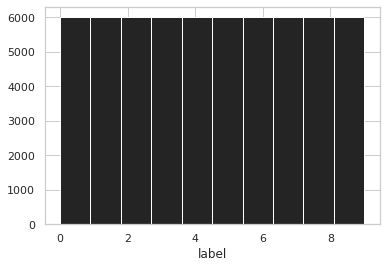

In [5]:
print('元データ(くずし字画像)：', original_imgs.shape)
print('元データ(正解ラベル)：', original_labels.shape)
print('訓練データ：', train_imgs.shape)
print('検証用データ：', validation_imgs.shape)
print('ラベルの範囲：', train_lbls.min(), '-', train_lbls.max())
print('ラベルの種類：', np.unique(train_lbls))
# print(train_imgs[0])

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('whitegrid')
sns.set_palette('gray')

train_labels = np.load("/content/drive/MyDrive/九工大/研究室/DataScience/CrushedCharactersIdentification/data/input/kmnist-train-labels.npz")['arr_0']

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(train_labels)
ax.set_xlabel('label')
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt

class RandomPlotter(object):
    def __init__(self):
        self.label_char = ["お(o)", "き(ki)", "す(su)", "つ(tsu)",\
                           "な(na)", "は(ha)", "ま(ma)", "や(ya)",\
                           "れ(re)", "を(wo)"]
        plt.rcParams['font.family'] = 'IPAPGothic'

    def _get_unique_labels(self, labels: np.ndarray) -> np.ndarray:
        label_unique = np.sort(np.unique(labels))
        return label_unique

    def _get_random_idx_list(self, labels: np.ndarray) -> list:
        label_unique = self._get_unique_labels(labels)

        random_idx_list = []
        for label in label_unique:
            label_indices = np.where(labels == label)[0]
            random_idx = np.random.choice(label_indices)
            random_idx_list.append(random_idx)

        return random_idx_list

    def plot(self, images: np.ndarray, labels: np.ndarray) -> None:
        """
        Parameters
        ----------
        images : np.ndarray
        train_imgs or validation_imgs

        labels : np.ndarray
        train_lbls or validation_lbls
        """
        random_idx_list = self._get_random_idx_list(labels)

        fig = plt.figure()
        for i, idx in enumerate(random_idx_list):
            ax = fig.add_subplot(2, 5, i+1)
            ax.tick_params(labelbottom=False, bottom=False)
            ax.tick_params(labelleft=False, left=False)
            img = images[idx]
            ax.imshow(img, cmap='gray')
            ax.set_title(self.label_char[i])
        fig.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12362 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12362 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12365 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12365 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12377 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12377 missing from current font.
  font.set_text

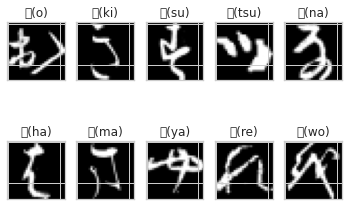

In [11]:
# 訓練データ確認
RandomPlotter().plot(train_imgs, train_lbls)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12362 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12362 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12365 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12365 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12377 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12377 missing from current font.
  font.set_text

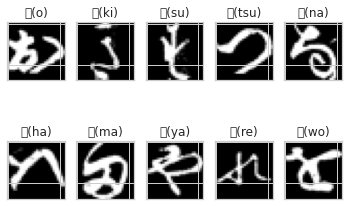

In [12]:
# 訓練データ確認
RandomPlotter().plot(validation_imgs, validation_lbls)

# 前処理


*   数値データの型をfloat32へキャスト
*   画像のndarrayのshapeを(N, 28, 28)から(N, 28, 28, 1)にキャスト（Nは画像の枚数）
*   値を[0, 255]から[0, 1]に正規化

In [13]:
import numpy as np
from tensorflow.keras.utils import to_categorical

class Preprocessor(object):
    def transform(self, train_imgs, train_lbls, validation_imgs, validation_lbls):
        train_imgs, validation_imgs = self._convert_imgs_dtypes(train_imgs, validation_imgs)
        train_imgs, validation_imgs = self._convert_imgs_shape(train_imgs, validation_imgs)
        train_imgs, validation_imgs = self._normalize(train_imgs, validation_imgs)

        train_lbls, validation_lbls = self._to_categorical_labels(train_lbls, validation_lbls)
        return train_imgs, train_lbls, validation_imgs, validation_lbls

    def _convert_imgs_dtypes(self, train_imgs, validation_imgs):
        _train_imgs = train_imgs.astype('float32')
        _validation_imgs = validation_imgs.astype('float32')
        return _train_imgs, _validation_imgs

    def _convert_imgs_shape(self, train_imgs, validation_imgs):
        _train_imgs = train_imgs[...,np.newaxis]
        _validation_imgs = validation_imgs[...,np.newaxis]
        return _train_imgs, _validation_imgs

    def _normalize(self, train_imgs, validation_imgs):
        _train_imgs = train_imgs / 255.0
        _validation_imgs = validation_imgs / 255.0
        return _train_imgs, _validation_imgs

    def _to_categorical_labels(self, train_lbls, validation_lbls):
        label_num = len(np.unique(train_lbls))
        _train_lbls = to_categorical(train_lbls, label_num)
        _validation_lbls = to_categorical(validation_lbls, label_num)
        return _train_lbls, _validation_lbls

train_imgs, train_lbls, validation_imgs, validation_lbls = Preprocessor().transform(train_imgs, train_lbls, validation_imgs, validation_lbls)

# kerasを用いて簡易なCNNを作成して識別

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1600)             

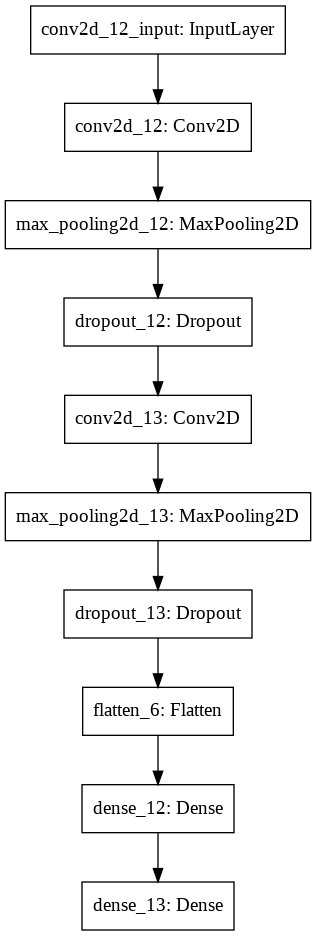

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

# dataの準備
train_imgs, train_lbls, validation_imgs, validation_lbls = KMNISTDataLoader(validation_size).load(datapath)
train_imgs, train_lbls, validation_imgs, validation_lbls = Preprocessor().transform(train_imgs, train_lbls, validation_imgs, validation_lbls)

# modelの設定
label_num = 10
input_shape = (28, 28, 1)

# model作成
# Sequential：モデル層を積み重ねる形式の記述方法。.addメソッドで簡単に層を追加できる。
model = Sequential()

# Conv2D：2次元畳み込み層。空間フィルタ – 畳み込み演算層。
# 32種類の「3×3」のフィルタ
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# プーリング層
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# ドロップアウト層(過学習防止用, dropoutレートが0.25なら512個のユニットのうち、25%のユニットを無効化）
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))
# 平準化層
model.add(layers.Flatten())
# 全結合層
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(label_num, activation='softmax'))

# モデルの構造
model.summary()

# モデルをプロット
plot_model(model)

# モデルの学習

In [38]:
# バッチサイズ：1度に学習するデータサイズ
batch_size = 128
# エポック数：学習回数
epochs = 30

# 学習プロセスの設定する
loss = keras.losses.categorical_crossentropy
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# modelを学習する
history = model.fit(train_imgs, train_lbls,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(validation_imgs, validation_lbls))



# modelを評価する
train_score = model.evaluate(train_imgs, train_lbls)
validation_score = model.evaluate(validation_imgs, validation_lbls)
print('Train loss :', train_score[0])
print('Train accuracy :', train_score[1])
print('validation loss :', validation_score[0])
print('validation accuracy :', validation_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
375/375 [==============================] - 92s 109ms/step - loss: 0.0083 - accuracy: 0.9971 - val_loss: 0.0603 - val_accuracy: 0.9876
Epoch 2/30
375/375 [==============================] - 41s 109ms/step - loss: 0.0083 - accuracy: 0.9972 - val_loss: 0.0604 - val_accuracy: 0.9881
Epoch 3/30
375/375 [==============================] - 41s 109ms/step - loss: 0.0098 - accuracy: 0.9967 - val_loss: 0.0602 - val_accuracy: 0.9873
Epoch 4/30
375/375 [==============================] - 41s 110ms/step - loss: 0.0097 - accuracy: 0.9966 - val_loss: 0.0544 - val_accuracy: 0.9891
Epoch 5/30
375/375 [==============================] - 41s 109ms/step - loss: 0.0078 - accuracy: 0.9974 - val_loss: 0.0511 - val_accuracy: 0.9897
Epoch 6/30
375/375 [==============================] - 41s 109ms/step - loss: 0.0098 - accuracy: 0.9967 - val_loss: 0.0542 - val_accuracy: 0.9887
Epoch 7/30
375/375 [==============================] - 41s 109ms/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 0.0580 - val_ac

# 学習曲線の描画

findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


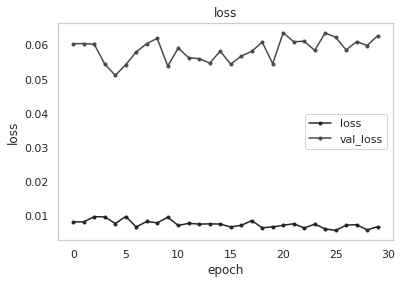

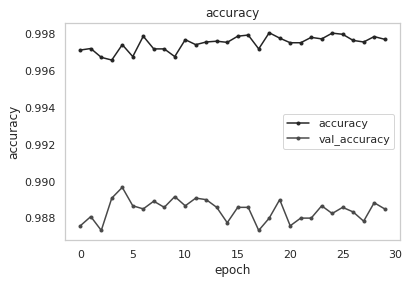

In [39]:
# 学習曲線の作成
plt.plot(history.history["loss"], marker=".", label="loss")
plt.plot(history.history["val_loss"], marker=".", label="val_loss")
plt.title("loss")
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()

plt.plot(history.history["accuracy"], marker=".", label="accuracy")
plt.plot(history.history["val_accuracy"], marker=".", label="val_accuracy")
plt.title("accuracy")
plt.grid()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.show()

# 識別結果の出力

In [40]:
class TestPreprocessor(object):
    def transform(self, imgs):
        imgs = self._convert_imgs_dtypes(imgs)
        imgs = self._convert_imgs_shape(imgs)
        imgs = self._normalize(imgs)
        return imgs

    def _convert_imgs_dtypes(self, imgs):
        _imgs = imgs.astype('float32')
        return _imgs
    
    def _convert_imgs_shape(self, imgs):
        _imgs = imgs[...,np.newaxis]
        return _imgs

    def _normalize(self, imgs):
        _imgs = imgs / 255.0
        return _imgs

In [41]:
# テストデータを読み込んで、前処理後、作成したモデルで予測
test_imgs = np.load("/content/drive/MyDrive/九工大/研究室/DataScience/CrushedCharactersIdentification/data/input/kmnist-test-imgs.npz")['arr_0']
test_imgs = TestPreprocessor().transform(test_imgs)
predict_lbls = model.predict(test_imgs)
predict_lbls = np.argmax(predict_lbls, axis=1)

In [42]:
# 予測結果を指定フォーマットに整形
import pandas as pd
df = pd.DataFrame(predict_lbls, columns=['Label'])
df.index.name = 'ImageId'
df.index = df.index + 1
df.head()

,Label
ImageId,
1,2
2,9
3,3
4,8
5,3


In [43]:
# 整形した予測データをcsvファイルに出力
df.to_csv('/content/drive/MyDrive/九工大/研究室/DataScience/CrushedCharactersIdentification/data/output/predict.csv', float_format='%.5f')

# 誤識別したデータの確認

In [27]:
class MisclassifiedDataPlotter(object):
    """
    このクラスへの入力はpreprocess処理済みのデータを仮定する．
    """
    def __init__(self):
        self.label_char = ["お(o)", "き(ki)", "す(su)", "つ(tsu)",\
        "な(na)", "は(ha)", "ま(ma)", "や(ya)",\
        "れ(re)", "を(wo)"]
        plt.rcParams['font.family'] = 'IPAPGothic'

    def _convert_onehot2intvec(self, labels):
        labels_int_vec = np.argmax(labels, axis=1)
        return labels_int_vec

    def _get_mixclassified_idx_list(self, labels_intvec, pred_labels_intvec):
        misclassified = labels_intvec != pred_labels_intvec
        mis_idxs_list = np.where(misclassified == True)[0]

        return mis_idxs_list

    def plot(self, images, labels, pred_labels, plot_num: int=5):
        """
        >>> images.shape
        (10000, 28, 28, 1)

        >>> labels
        array([[0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

        >>> pred_labels
        array([[2.8434190e-06, 4.1375683e-06, 9.9899501e-01, ..., 3.7393205e-05,
        2.5519948e-05, 3.0874473e-04],
        ...,
        [4.1747628e-09, 1.8852282e-07, 9.9982470e-01, ..., 1.4897050e-07,
        7.9116326e-05, 3.7392081e-05]], dtype=float32)
        """
        labels_intvec = self._convert_onehot2intvec(labels)
        pred_labels_intvec = self._convert_onehot2intvec(pred_labels)

        mis_idxs_list = self._get_mixclassified_idx_list(labels_intvec, pred_labels_intvec)
        random_idx_list = list(np.random.choice(mis_idxs_list, size=plot_num, replace=False))

        fig = plt.figure()
        for i, idx in enumerate(random_idx_list):
            ax = fig.add_subplot(1, plot_num, i+1)
            ax.tick_params(labelbottom=False, bottom=False)
            ax.tick_params(labelleft=False, left=False)
            img = images[idx].reshape((28,28)) # (28, 28, 1) -> (28, 28)
            ax.imshow(img, cmap='gray')

            actual_label = self.label_char[labels_intvec[idx]]
            print(labels_intvec[idx])
            pred_label = self.label_char[pred_labels_intvec[idx]]
            ax.set_title(f"{pred_label} : actual {actual_label}")
        fig.show()

5
5
2
4
3


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12388 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12399 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12388 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12399 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12420 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12420 missing from current font.
  font.set_text

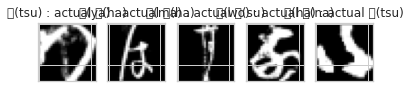

In [28]:
prediction = model.predict(validation_imgs) # このmodelは上で作成したkerasのCNNです．

mis_plotter = MisclassifiedDataPlotter()
mis_plotter.plot(validation_imgs, validation_lbls, prediction, plot_num=5)